In [1]:
!pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attemptin

In [2]:
import os
import numpy as np
import torch
import random
from glob import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import timm  # for pretrained ViT models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import f1_score, confusion_matrix


In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
class AlzheimerDataset(Dataset):
    def __init__(self, root, data_type, transform=None):
        self.transform = transform
        self.image_paths = glob(f"{root}/{data_type}/*/*")
        self.classes = sorted({os.path.basename(os.path.dirname(p)) for p in self.image_paths})
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[os.path.basename(os.path.dirname(img_path))]
        if self.transform:
            image = self.transform(image)
        return image, label


In [5]:
root = "/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load full dataset
train_dataset = AlzheimerDataset(root=root, data_type="train", transform=transform)
train_len = int(0.8 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_ds, val_ds = random_split(train_dataset, [train_len, val_len])

# Load test dataset
test_dataset = AlzheimerDataset(root=root, data_type="test", transform=transform)



train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

classes = train_dataset.classes
num_classes = len(classes)
print(f"Total test samples: {len(test_dataset)}")


Total test samples: 1279


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import timm
import os
import numpy as np
from torchvision import transforms

# === Setup ===
model_name = "vit_large_patch16_224"
save_prefix = "mri_vit_finetuned"
save_dir = "saved_models"
device = "cuda" if torch.cuda.is_available() else "cpu"

# === Data Augmentation & Normalization ===

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),                      # Slightly larger resize before crop
    transforms.RandomCrop((224, 224), padding=4),       # Helps with spatial robustness
    transforms.RandomHorizontalFlip(p=0.5),             # Mirror image
    transforms.RandomVerticalFlip(p=0.2),               # Less frequent than horizontal flip
    transforms.RandomRotation(degrees=15),              # Minor orientation shifts
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Simulate lighting variations
    transforms.RandomGrayscale(p=0.1),                  # Reduce color reliance
    transforms.RandAugment(num_ops=2, magnitude=9),     # Add two random ops (robust)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


# === Extract labels from original dataset ===
train_labels = []
for i in train_ds.indices:
    _, label = train_dataset[i]
    train_labels.append(label)
num_classes = len(np.unique(train_labels)) 

# === Initialize ViT and remove default head ===
model = timm.create_model(model_name=model_name, pretrained=True)
model.reset_classifier(0) 

# === Define Custom Classification Head ===
model.head = nn.Sequential(
    nn.LayerNorm(model.num_features),
    nn.Linear(model.num_features, 512),
    nn.GELU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.GELU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)


# === Unfreeze all transformer blocks ===
for param in model.parameters():
    param.requires_grad = True

# === Ensure LayerNorm layers are also trainable ===
for name, param in model.named_parameters():
    if "norm" in name:
        param.requires_grad = True

model = model.to(device)

# === Compute class weights from training labels ===
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# === Loss Function: CrossEntropy with Label Smoothing ===
criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)

# === Optimizer ===
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# === Scheduler: Cosine Annealing with Warm Restarts ===
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

print("ViT model fully initialized with custom head and advanced fine-tuning settings.")


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

ViT model fully initialized with custom head and advanced fine-tuning settings.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
import os
import torchmetrics
from tqdm import tqdm
import torch

class TrainValidation:
    def __init__(self, model, classes, tr_dl, val_dl, criterion, optimizer, scheduler, device,
                 save_dir="saved_models", save_prefix="model",
                 epochs=20, patience=5, threshold=0.01, dev_mode=False):

        self.model = model.to(device)
        self.classes = classes
        self.tr_dl = tr_dl
        self.val_dl = val_dl
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

        self.save_dir = save_dir
        self.save_prefix = save_prefix
        self.epochs = epochs
        self.patience = patience
        self.threshold = threshold
        self.dev_mode = dev_mode

        self.f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(device)

        os.makedirs(save_dir, exist_ok=True)
        self.best_acc = 0
        self.not_improved = 0

        self.tr_losses, self.val_losses = [], []
        self.tr_accs, self.val_accs = [], []
        self.tr_f1s, self.val_f1s = [], []

    @staticmethod
    def to_device(batch, device):
        ims, gts = batch
        return ims.to(device), gts.to(device)

    def train_epoch(self):
        self.model.train()
        total_loss, correct = 0.0, 0
        self.f1_metric.reset()

        for idx, batch in tqdm(enumerate(self.tr_dl), desc="Training", total=len(self.tr_dl)):
            if self.dev_mode and idx > 1:
                break

            ims, gts = self.to_device(batch, self.device)

            preds = self.model(ims)
            loss = self.criterion(preds, gts)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            correct += (preds.argmax(1) == gts).sum().item()
            self.f1_metric.update(preds, gts)

        avg_loss = total_loss / len(self.tr_dl)
        avg_acc = correct / len(self.tr_dl.dataset)
        avg_f1 = self.f1_metric.compute().item()

        self.tr_losses.append(avg_loss)
        self.tr_accs.append(avg_acc)
        self.tr_f1s.append(avg_f1)

        return avg_loss, avg_acc, avg_f1

    def validate_epoch(self):
        self.model.eval()
        total_loss, correct = 0.0, 0
        self.f1_metric.reset()

        with torch.no_grad():
            for idx, batch in tqdm(enumerate(self.val_dl), desc="Validation", total=len(self.val_dl)):
                if self.dev_mode and idx > 1:
                    break

                ims, gts = self.to_device(batch, self.device)

                preds = self.model(ims)
                loss = self.criterion(preds, gts)

                total_loss += loss.item()
                correct += (preds.argmax(1) == gts).sum().item()
                self.f1_metric.update(preds, gts)

        avg_loss = total_loss / len(self.val_dl)
        avg_acc = correct / len(self.val_dl.dataset)
        avg_f1 = self.f1_metric.compute().item()

        self.val_losses.append(avg_loss)
        self.val_accs.append(avg_acc)
        self.val_f1s.append(avg_f1)

        return avg_loss, avg_acc, avg_f1

    def save_best_model(self, val_f1):
        if val_f1 > self.best_acc:
            self.best_acc = val_f1
            save_path = os.path.join(self.save_dir, f"{self.save_prefix}_best_model.pth")
            torch.save(self.model.state_dict(), save_path)
            print(f"Best model saved with F1-Score: {val_f1:.3f}")
            self.not_improved = 0
        else:
            self.not_improved += 1
            print(f"No improvement for {self.not_improved} epoch(s).")

    def run(self):
        print("Starting fine-tuned training...\n")
        for epoch in range(self.epochs):
            if self.dev_mode and epoch > 1:
                break

            print(f"=== Epoch {epoch + 1}/{self.epochs} ===")
            train_loss, train_acc, train_f1 = self.train_epoch()
            print(f"Train — Loss: {train_loss:.3f} | Acc: {train_acc:.3f} | F1: {train_f1:.3f}")

            val_loss, val_acc, val_f1 = self.validate_epoch()
            print(f"Val   — Loss: {val_loss:.3f} | Acc: {val_acc:.3f} | F1: {val_f1:.3f}")

            self.save_best_model(val_f1)

            if self.scheduler is not None:
                self.scheduler.step(val_f1)

            if self.not_improved >= self.patience:
                print("Early stopping triggered.")
                break

        print(" Training completed.")

trainer = TrainValidation(
    model=model,
    classes=classes,
    tr_dl=train_dl,
    val_dl=val_dl,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir=save_dir,
    save_prefix=save_prefix,
    epochs=20,
    patience=5,
    threshold=0.01,
    dev_mode=False
)
trainer.run()


Starting fine-tuned training...

=== Epoch 1/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.820 | Acc: 0.717 | F1: 0.717


Validation: 100%|██████████| 64/64 [00:52<00:00,  1.23it/s]


Val   — Loss: 0.644 | Acc: 0.835 | F1: 0.835
Best model saved with F1-Score: 0.835
=== Epoch 2/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.590 | Acc: 0.869 | F1: 0.869


Validation: 100%|██████████| 64/64 [00:44<00:00,  1.44it/s]


Val   — Loss: 0.513 | Acc: 0.917 | F1: 0.917
Best model saved with F1-Score: 0.917
=== Epoch 3/20 ===


Training: 100%|██████████| 256/256 [08:32<00:00,  2.00s/it]


Train — Loss: 0.481 | Acc: 0.938 | F1: 0.938


Validation: 100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


Val   — Loss: 0.455 | Acc: 0.943 | F1: 0.943
Best model saved with F1-Score: 0.943
=== Epoch 4/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.432 | Acc: 0.962 | F1: 0.962


Validation: 100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Val   — Loss: 0.470 | Acc: 0.937 | F1: 0.937
No improvement for 1 epoch(s).
=== Epoch 5/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.400 | Acc: 0.977 | F1: 0.977


Validation: 100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


Val   — Loss: 0.420 | Acc: 0.970 | F1: 0.970
Best model saved with F1-Score: 0.970
=== Epoch 6/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.400 | Acc: 0.978 | F1: 0.978


Validation: 100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


Val   — Loss: 0.559 | Acc: 0.905 | F1: 0.905
No improvement for 1 epoch(s).
=== Epoch 7/20 ===


Training: 100%|██████████| 256/256 [08:32<00:00,  2.00s/it]


Train — Loss: 0.385 | Acc: 0.985 | F1: 0.985


Validation: 100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Val   — Loss: 0.406 | Acc: 0.971 | F1: 0.971
Best model saved with F1-Score: 0.971
=== Epoch 8/20 ===


Training: 100%|██████████| 256/256 [08:32<00:00,  2.00s/it]


Train — Loss: 0.370 | Acc: 0.991 | F1: 0.991


Validation: 100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


Val   — Loss: 0.452 | Acc: 0.951 | F1: 0.951
No improvement for 1 epoch(s).
=== Epoch 9/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.388 | Acc: 0.984 | F1: 0.984


Validation: 100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


Val   — Loss: 0.376 | Acc: 0.987 | F1: 0.987
Best model saved with F1-Score: 0.987
=== Epoch 10/20 ===


Training: 100%|██████████| 256/256 [08:32<00:00,  2.00s/it]


Train — Loss: 0.377 | Acc: 0.989 | F1: 0.989


Validation: 100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


Val   — Loss: 0.402 | Acc: 0.974 | F1: 0.974
No improvement for 1 epoch(s).
=== Epoch 11/20 ===


Training: 100%|██████████| 256/256 [08:30<00:00,  1.99s/it]


Train — Loss: 0.396 | Acc: 0.979 | F1: 0.979


Validation: 100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Val   — Loss: 0.401 | Acc: 0.973 | F1: 0.973
No improvement for 2 epoch(s).
=== Epoch 12/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.379 | Acc: 0.989 | F1: 0.989


Validation: 100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Val   — Loss: 0.385 | Acc: 0.982 | F1: 0.982
No improvement for 3 epoch(s).
=== Epoch 13/20 ===


Training: 100%|██████████| 256/256 [08:30<00:00,  1.99s/it]


Train — Loss: 0.358 | Acc: 0.998 | F1: 0.998


Validation: 100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


Val   — Loss: 0.375 | Acc: 0.987 | F1: 0.987
No improvement for 4 epoch(s).
=== Epoch 14/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.354 | Acc: 1.000 | F1: 1.000


Validation: 100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Val   — Loss: 0.369 | Acc: 0.989 | F1: 0.989
Best model saved with F1-Score: 0.989
=== Epoch 15/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.353 | Acc: 1.000 | F1: 1.000


Validation: 100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Val   — Loss: 0.370 | Acc: 0.987 | F1: 0.987
No improvement for 1 epoch(s).
=== Epoch 16/20 ===


Training: 100%|██████████| 256/256 [08:30<00:00,  2.00s/it]


Train — Loss: 0.353 | Acc: 1.000 | F1: 1.000


Validation: 100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


Val   — Loss: 0.370 | Acc: 0.988 | F1: 0.988
No improvement for 2 epoch(s).
=== Epoch 17/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.352 | Acc: 1.000 | F1: 1.000


Validation: 100%|██████████| 64/64 [00:44<00:00,  1.44it/s]


Val   — Loss: 0.370 | Acc: 0.986 | F1: 0.986
No improvement for 3 epoch(s).
=== Epoch 18/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.352 | Acc: 1.000 | F1: 1.000


Validation: 100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


Val   — Loss: 0.370 | Acc: 0.988 | F1: 0.988
No improvement for 4 epoch(s).
=== Epoch 19/20 ===


Training: 100%|██████████| 256/256 [08:31<00:00,  2.00s/it]


Train — Loss: 0.352 | Acc: 1.000 | F1: 1.000


Validation: 100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

Val   — Loss: 0.370 | Acc: 0.988 | F1: 0.988
No improvement for 5 epoch(s).
Early stopping triggered.
 Training completed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38339 sha256=5ea2df583cf6e95eda87215515ae34ca22d02656acb36bcf771b5fbee3ce39f4
  Stored in directory: /root/.cache/pip/wheels/5d/90/92/0661d038b2e6ce71cad21432f92c50b1d79887bd5eb82ff3b1
Successfully built grad-cam


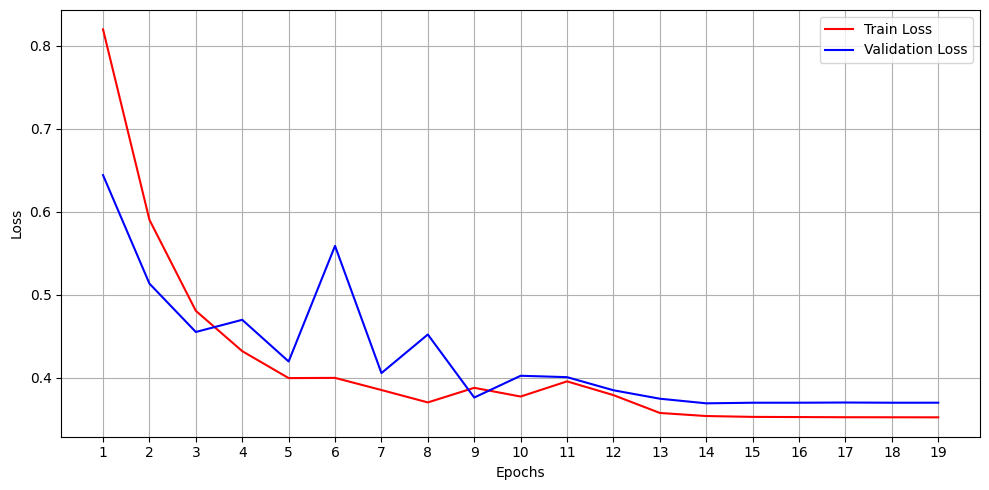

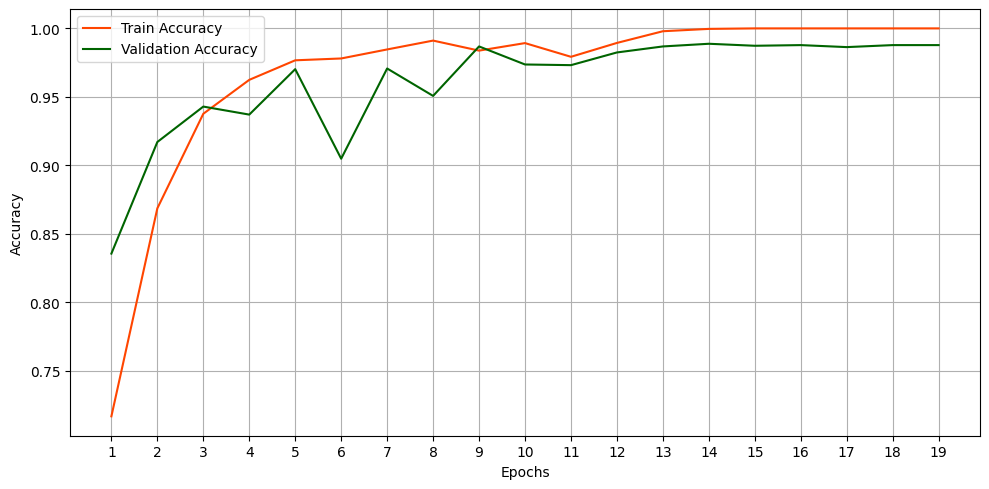

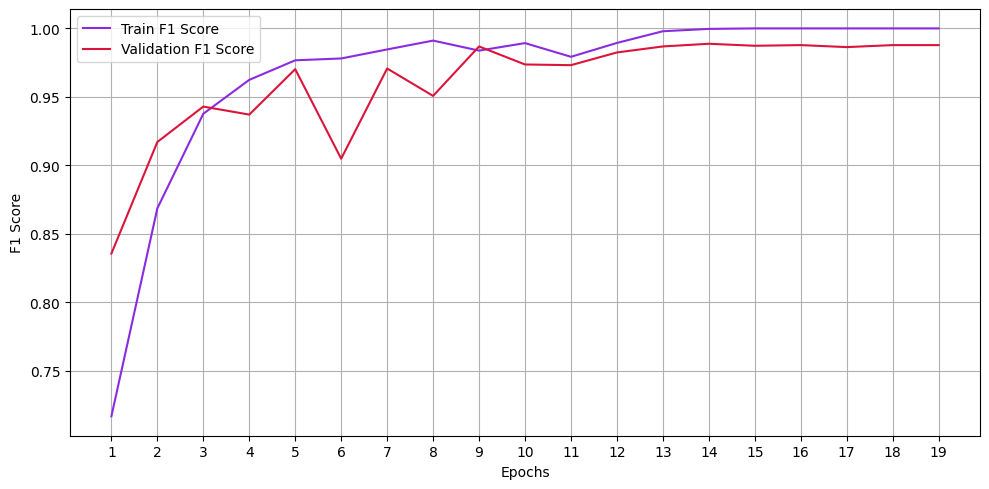

In [8]:
!pip install grad-cam==1.4.6

import matplotlib.pyplot as plt
import numpy as np

class PlotLearningCurves:
    
    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        self.tr_losses = tr_losses
        self.val_losses = val_losses
        self.tr_accs = tr_accs
        self.val_accs = val_accs
        self.tr_f1s = tr_f1s
        self.val_f1s = val_f1s

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        plt.plot(array_1, label=label_1, color=color_1)
        plt.plot(array_2, label=label_2, color=color_2)

    def create_figure(self):
        plt.figure(figsize=(10, 5))

    def decorate(self, ylabel, xlabel="Epochs"):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(ticks=np.arange(len(self.tr_accs)), labels=[i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def visualize(self):
        # Loss Plot
        self.create_figure()
        self.plot(self.tr_losses, self.val_losses, "Train Loss", "Validation Loss", "red", "blue")
        self.decorate(ylabel="Loss")

        # Accuracy Plot
        self.create_figure()
        self.plot(self.tr_accs, self.val_accs, "Train Accuracy", "Validation Accuracy", "orangered", "darkgreen")
        self.decorate(ylabel="Accuracy")

        # F1 Score Plot
        self.create_figure()
        self.plot(self.tr_f1s, self.val_f1s, "Train F1 Score", "Validation F1 Score", "blueviolet", "crimson")
        self.decorate(ylabel="F1 Score")

# Call this after training completes
PlotLearningCurves(
    tr_losses=trainer.tr_losses,
    val_losses=trainer.val_losses,
    tr_accs=trainer.tr_accs,
    val_accs=trainer.val_accs,
    tr_f1s=trainer.tr_f1s,
    val_f1s=trainer.val_f1s
).visualize()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00


/tmp/ipykernel_19/2045428125.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(save_dir, f"{save_prefix}_best_model.pth"), map_locati


=== Test Accuracy ===
Accuracy: 97.81% (1251/1279)


=== Classification Report ===

                      precision    recall  f1-score   support

     Mild Impairment      0.983     0.978     0.980       179
 Moderate Impairment      1.000     1.000     1.000        12
       No Impairment      0.980     0.984     0.982       640
Very Mild Impairment      0.973     0.969     0.971       448

            accuracy                          0.978      1279
           macro avg      0.984     0.983     0.983      1279
        weighted avg      0.978     0.978     0.978      1279



<Figure size 600x600 with 0 Axes>

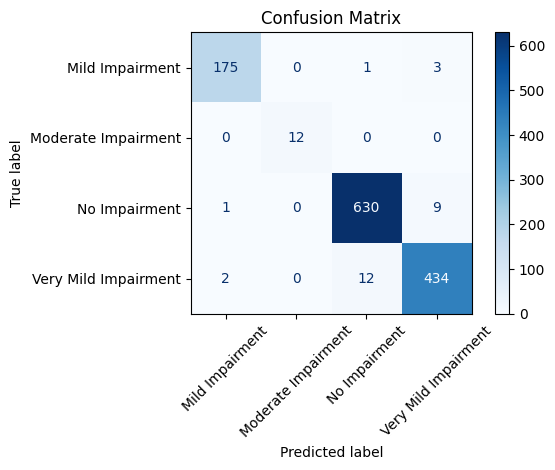

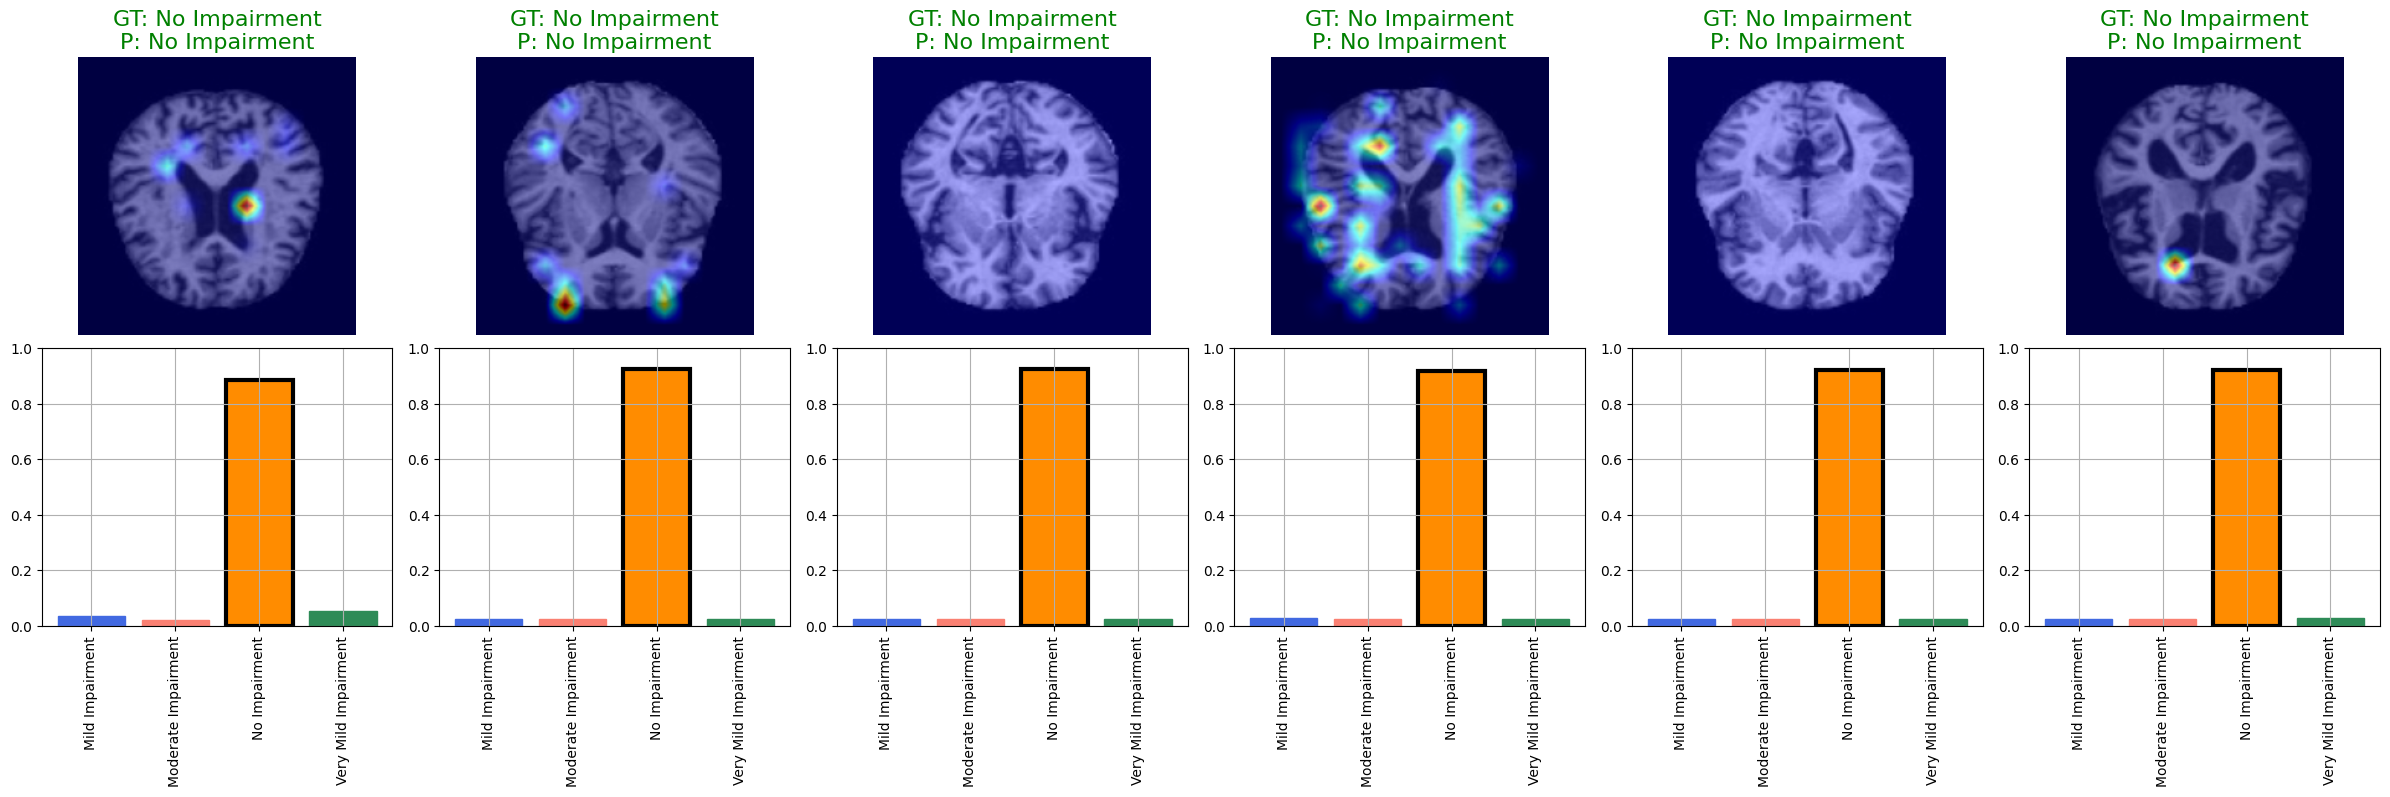

In [9]:

!pip install gradio

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torchvision import transforms
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image
import gradio as gr

# ==== Setup ====
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define your class labels
# class_names = ['No Impairment', 'Very Mild Impairment', 'Mild Impairment', 'Moderate Impairment']

# Correct class order based on folder index mapping
class_names = train_dataset.classes


# Load model and weights
state_dict = torch.load(os.path.join(save_dir, f"{save_prefix}_best_model.pth"), map_location=device)
model.load_state_dict(state_dict)
model.eval().to(device)

# Select Grad-CAM target layer
try:
    target_layer = model.blocks[-1].norm1
except AttributeError:
    try:
        target_layer = model.blocks[-1].mlp
    except AttributeError:
        target_layer = model.blocks[-1].attn

# Grad-CAM reshape function for ViT
def vit_reshape_transform(tensor):
    tensor = tensor[:, 1:, :]
    B, N, C = tensor.shape
    h = w = int(N ** 0.5)
    return tensor.reshape(B, h, w, C).permute(0, 3, 1, 2)

# ==== Inference on test set ====
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ==== Test Accuracy ====
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)
accuracy = correct / total
print(f"\n=== Test Accuracy ===\nAccuracy: {accuracy * 100:.2f}% ({correct}/{total})\n")

# ==== Classification Report ====
print("\n=== Classification Report ===\n")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

# ==== Confusion Matrix ====
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


 # ==== Grad-CAM + Bar-Chart Visualization (6 Shuffled Images) ====
class_colors = {
    'No Impairment':     'darkorange',
    'Very Mild Impairment':'seagreen',
    'Moderate Impairment':'salmon',
    'Mild Impairment':   'royalblue'
}

cam = GradCAM(
    model=model,
    target_layers=[target_layer],
    use_cuda=(device.type == "cuda"),
    reshape_transform=vit_reshape_transform
)

# Sample 6 test images
sample_indices = random.sample(range(len(test_dataset)), 6)
sample_images = [test_dataset[i][0] for i in sample_indices]
sample_labels = [test_dataset[i][1] for i in sample_indices]

input_tensor = torch.stack(sample_images).to(device)
true_labels = torch.tensor(sample_labels).to(device)

with torch.no_grad():
    outputs = model(input_tensor)
    preds = outputs.argmax(dim=1)

# Grad-CAM maps
targets = [ClassifierOutputTarget(p.item()) for p in preds]
cam_maps = cam(input_tensor, targets=targets)

# Plot
fig, axes = plt.subplots(2, 6, figsize=(24, 8))

for i in range(6):
    img = input_tensor[i].cpu().permute(1,2,0).numpy()
    img = (img * 0.5) + 0.5  # De-normalize (adjust if you used different normalization)
    img = np.clip(img, 0, 1)

    cam_map = cv2.resize(cam_maps[i], (img.shape[1], img.shape[0]))
    overlay = show_cam_on_image(img, cam_map, use_rgb=True)

    # --- Top Row: CAM overlays ---
    ax_cam = axes[0, i]
    ax_cam.imshow(overlay)
    ax_cam.set_title(
        f"GT: {class_names[true_labels[i]]}\nP: {class_names[preds[i]]}",
        color="green" if preds[i]==true_labels[i] else "red",
        fontsize=16
    )
    ax_cam.axis("off")

    # --- Bottom Row: Softmax Bar Plot ---
    probs = torch.nn.functional.softmax(outputs[i].unsqueeze(0), dim=1)[0].cpu().numpy()
    pred_idx = preds[i].item()

    ax_bar = axes[1, i]
    for j, cls in enumerate(class_names):
        ax_bar.bar(
            j, probs[j],
            color=class_colors[cls],
            edgecolor='black' if j == pred_idx else class_colors[cls],
            linewidth=3 if j == pred_idx else 1
        )
    ax_bar.set_xticks(range(len(class_names)))
    ax_bar.set_xticklabels(class_names, rotation=90)
    ax_bar.set_ylim(0, 1)
    ax_bar.grid(True)

plt.tight_layout()
plt.show()



In [10]:
# ==== Gradio Interface ====
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

def predict_with_gradcam(image_pil):
    image_rgb = image_pil.convert("RGB")
    input_tensor = test_transform(image_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        label = class_names[pred_class]

    # Grad-CAM requires gradients
    targets = [ClassifierOutputTarget(pred_class)]
    cam_map = cam(input_tensor, targets=targets)[0]

    image_np = np.array(image_rgb).astype(np.float32) / 255.0
    cam_map_resized = cv2.resize(cam_map, (image_np.shape[1], image_np.shape[0]))
    cam_overlay = show_cam_on_image(image_np, cam_map_resized, use_rgb=True)

    return label, cam_overlay

gr.Interface(
    fn=predict_with_gradcam,
    inputs=gr.Image(type="pil", label="Upload MRI Image"),
    outputs=[gr.Label(label="Predicted Label"), gr.Image(label="Grad-CAM Heatmap")],
    title="ViT MRI Classifier",
    description="Upload an MRI to get predicted diagnosis and a Grad-CAM heatmap."
).launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://2237bae51bf6c2fed6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
